In [14]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from datasets import Dataset
import torch, re, math, requests, unicodedata, string
import matplotlib.pyplot as plt

In [ ]:
def load_and_clean_text(url):
  text = requests.get(url).text

  start = text.upper().find("*** START OF")
  if start != -1:
    text = text[start:]
  end = text.upper().rfind("*** END OF")
  if end != -1:
    text = text[:end]

  text = re.sub(r'(\n\s*)+', '\n', text)
  text = re.sub(r'[ \t\r\f\v]+', ' ', text)
  text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode()
  text = re.sub(r"\n\s*\n+", "\n", text)
  text = re.sub(r"\s+", " ", text).strip()

  allowed = set(string.printable)
  text = "".join(c for c in text if c in allowed)

  return text

Token indices sequence length is longer than the specified maximum sequence length for this model (89979 > 1024). Running this sequence through the model will result in indexing errors


Training using: 5e-05, 2, 0


Epoch,Training Loss,Validation Loss
1,3.611600,3.554478
2,3.148100,3.576081
3,2.863800,3.635066
4,2.664000,3.690891
5,2.535800,3.727889


Perplexity: 41.59120898899386


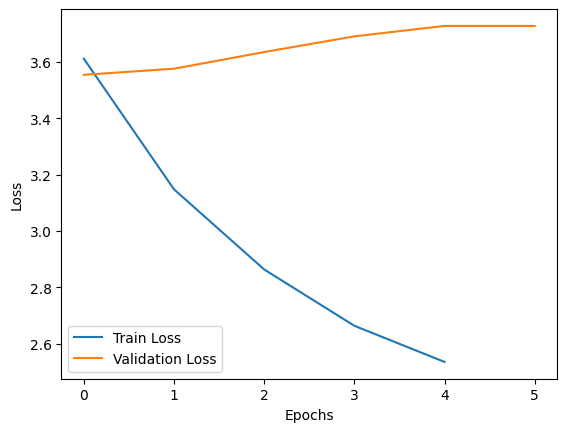

Training using: 5e-05, 4, 0


Epoch,Training Loss,Validation Loss
1,3.648400,3.552141
2,3.275500,3.547004
3,3.069200,3.577533
4,2.925100,3.593244
5,2.844300,3.610499


Perplexity: 36.98450878922701


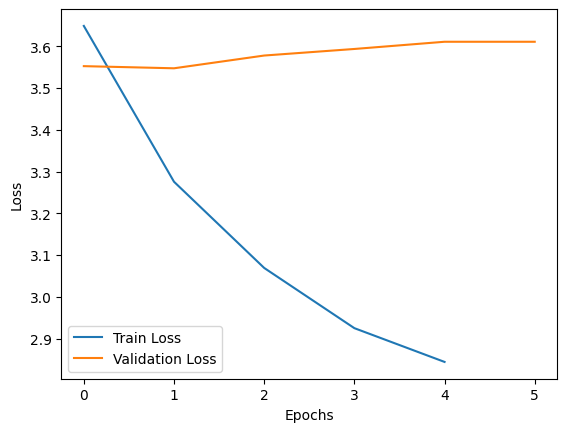

Training using: 0.0001, 2, 0


Epoch,Training Loss,Validation Loss
1,3.551600,3.583894
2,2.786400,3.701957
3,2.246500,3.980000
4,1.869300,4.235776
5,1.640000,4.376882


Perplexity: 79.58945422208274


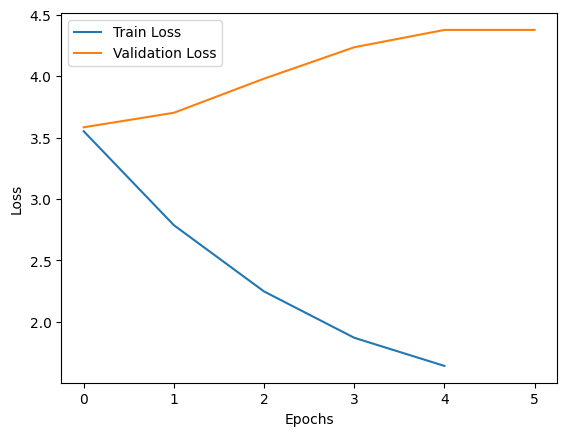

Training using: 0.0001, 4, 0


Epoch,Training Loss,Validation Loss
1,3.588700,3.558429
2,3.002200,3.605723
3,2.609900,3.738209
4,2.320400,3.856094
5,2.148000,3.942509


Perplexity: 51.54776924600789


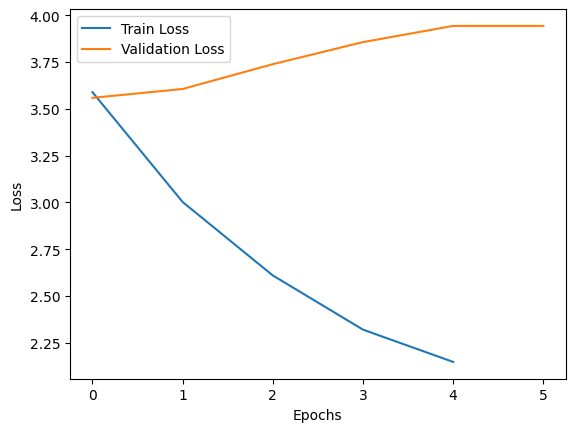

Training using: 0.0005, 2, 0


Epoch,Training Loss,Validation Loss
1,3.599000,3.932054
2,1.931200,4.867851
3,0.812700,6.028337
4,0.338900,6.557556
5,0.155600,6.771406


Perplexity: 872.5375556445383


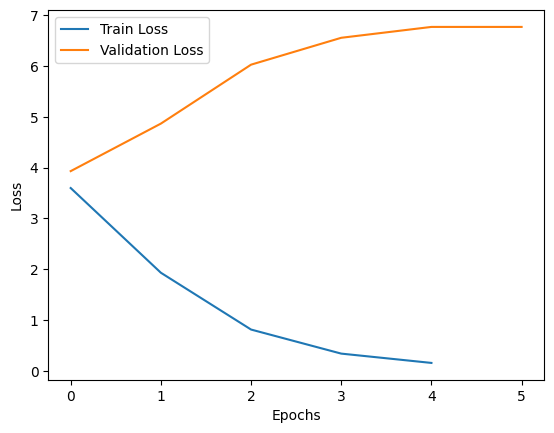

Training using: 0.0005, 4, 0


Epoch,Training Loss,Validation Loss
1,3.574300,3.805073
2,2.110600,4.470953
3,1.047400,5.501617
4,0.516500,5.990942
5,0.280400,6.258359


Perplexity: 522.3610186192356


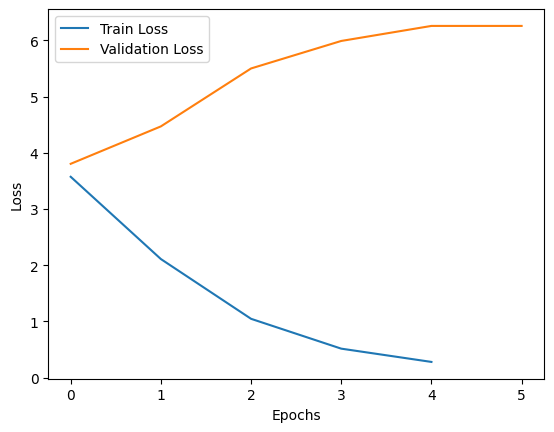

Training using: 5e-05, 2, 0.01


Epoch,Training Loss,Validation Loss
1,3.611700,3.554337
2,3.148300,3.576593
3,2.863900,3.634805
4,2.664000,3.690985
5,2.536000,3.727504


Perplexity: 41.57518763059033


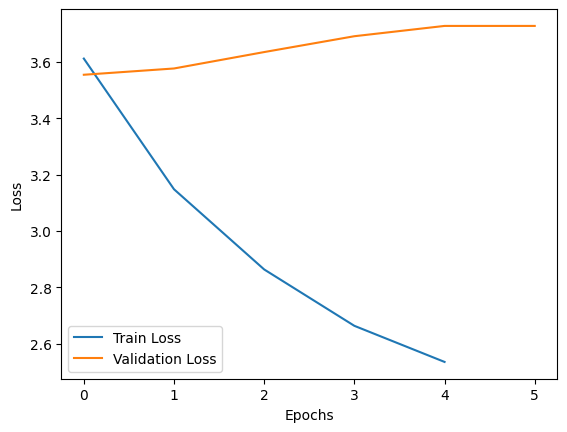

Training using: 5e-05, 4, 0.01


Epoch,Training Loss,Validation Loss
1,3.648400,3.552359
2,3.275400,3.547156
3,3.069100,3.578156
4,2.924800,3.593451
5,2.844000,3.610768


Perplexity: 36.994456598500534


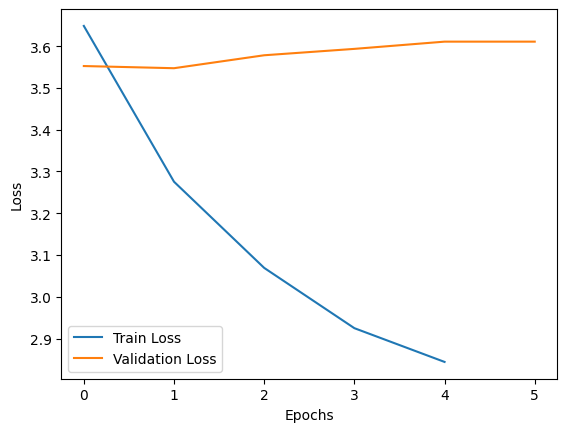

Training using: 0.0001, 2, 0.01


Epoch,Training Loss,Validation Loss
1,3.551200,3.582950
2,2.785200,3.702188
3,2.245300,3.980616
4,1.869500,4.232829
5,1.640800,4.375402


Perplexity: 79.47181659445417


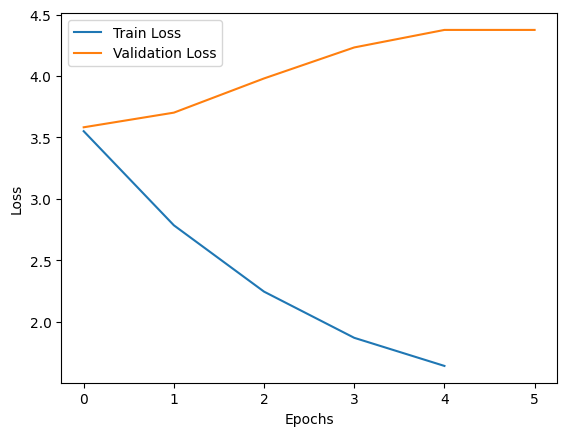

Training using: 0.0001, 4, 0.01


Epoch,Training Loss,Validation Loss
1,3.588400,3.557980
2,3.001800,3.605030
3,2.609200,3.737485
4,2.319600,3.856281
5,2.147000,3.943035


Perplexity: 51.57488799760951


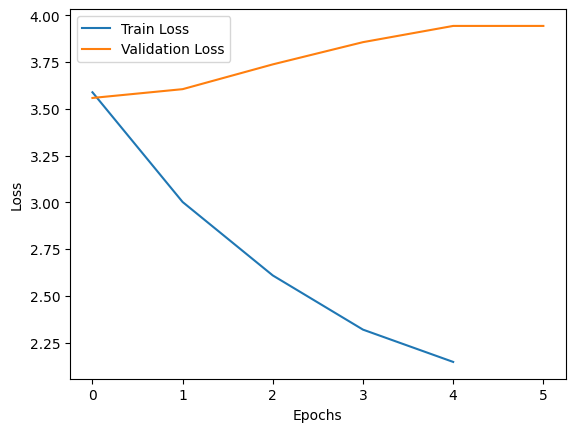

Training using: 0.0005, 2, 0.01


Epoch,Training Loss,Validation Loss
1,3.595600,3.930390
2,1.923800,4.888247
3,0.804000,6.017309
4,0.337300,6.516690
5,0.152500,6.740017


Perplexity: 845.5754606525518


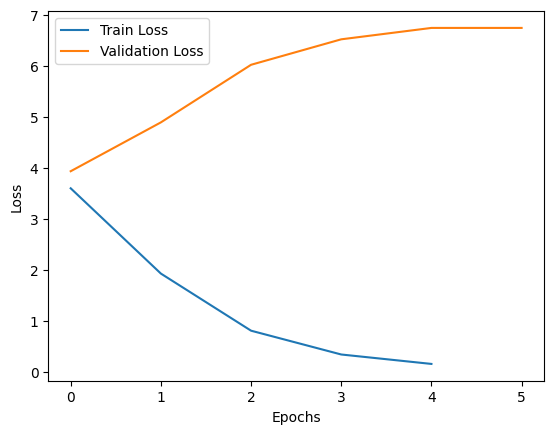

Training using: 0.0005, 4, 0.01


Epoch,Training Loss,Validation Loss
1,3.574800,3.811438
2,2.105000,4.455719
3,1.036500,5.562086
4,0.509400,6.038899
5,0.279500,6.269885


Perplexity: 528.4166398544651


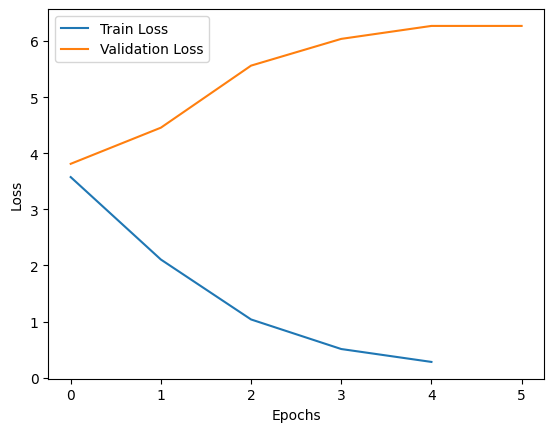

Training using: 5e-05, 2, 0.05


Epoch,Training Loss,Validation Loss
1,3.611700,3.553712
2,3.148000,3.576600
3,2.863600,3.634896
4,2.663200,3.691278
5,2.535000,3.728355


Perplexity: 41.61060943706486


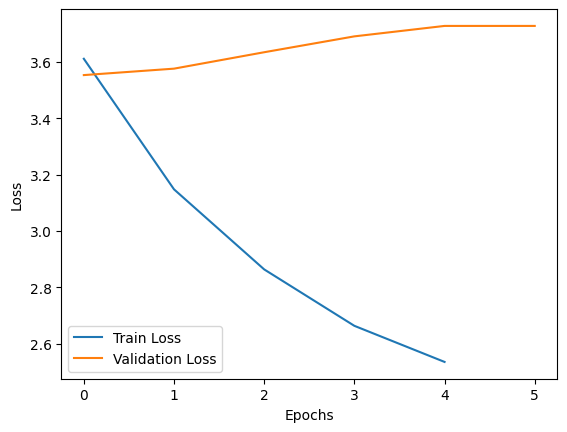

Training using: 5e-05, 4, 0.05


Epoch,Training Loss,Validation Loss
1,3.648200,3.552140
2,3.275000,3.546784
3,3.069000,3.578005
4,2.924900,3.593546
5,2.843700,3.610917


Perplexity: 36.99995196989629


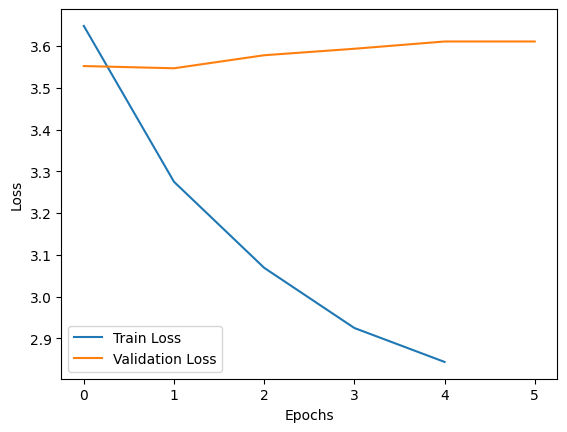

Training using: 0.0001, 2, 0.05


Epoch,Training Loss,Validation Loss
1,3.551100,3.583737
2,2.784000,3.704190
3,2.242400,3.981114
4,1.865500,4.238710
5,1.636200,4.381300


Perplexity: 79.94188814522332


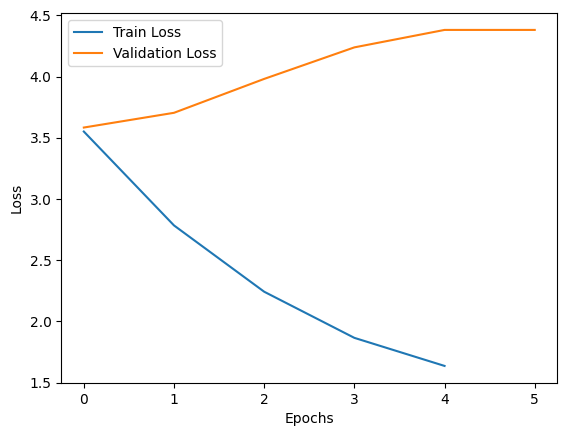

Training using: 0.0001, 4, 0.05


Epoch,Training Loss,Validation Loss
1,3.588300,3.558270
2,3.001200,3.605010
3,2.608200,3.737603
4,2.318300,3.856796
5,2.145500,3.943764


Perplexity: 51.612516440395765


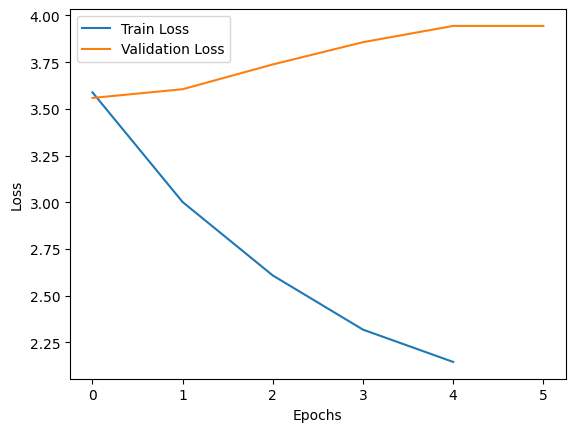

Training using: 0.0005, 2, 0.05


Epoch,Training Loss,Validation Loss
1,3.594000,3.916303
2,1.932800,4.872741
3,0.811800,5.973445
4,0.337400,6.496512
5,0.149800,6.701661


Perplexity: 813.7564419972498


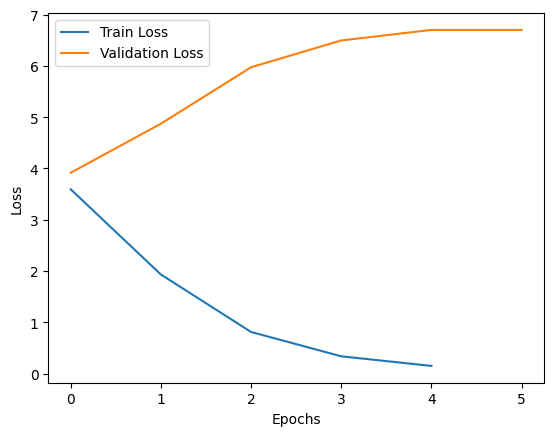

Training using: 0.0005, 4, 0.05


Epoch,Training Loss,Validation Loss
1,3.576500,3.817758
2,2.110700,4.453264
3,1.040200,5.487657
4,0.508900,5.971491
5,0.275500,6.230021


Perplexity: 507.765904304712


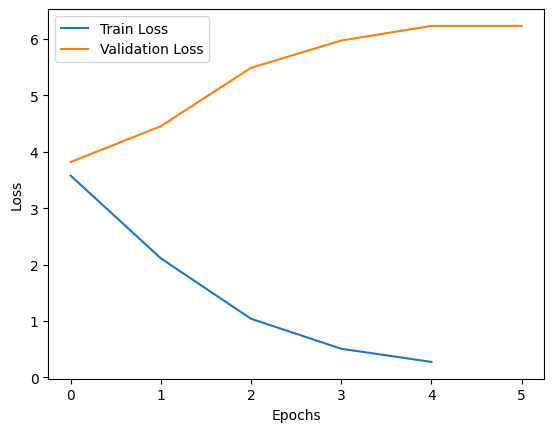

In [16]:
url = "https://www.gutenberg.org/cache/epub/84/pg84.txt"
text = load_and_clean_text(url)

lines = [line for line in text.split('.') if line.strip()]
dataset = Dataset.from_dict({"text": lines})

train_size = int(0.9 * len(dataset))

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

tokens = tokenizer.encode(text)

def make_sliding_windows(tokens, block_size=256, stride=128):
  examples = []
  for i in range(0, len(tokens) - block_size, stride):
    chunk = tokens[i : i + block_size]
    examples.append({"input_ids": chunk, "labels": chunk})
  return examples

examples = make_sliding_windows(tokens, block_size=256, stride=128)
processed_dataset = Dataset.from_list(examples)

split_dataset = processed_dataset.train_test_split(test_size=0.1, shuffle=False)
train_val_dataset = split_dataset['train']
test_dataset = split_dataset['test']

train_val_split = train_val_dataset.train_test_split(test_size=0.1, shuffle=False)
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

hyperparameter_dict = {
  "lr": [5e-5, 1e-4, 5e-4],
  "batch_size": [2, 4],
  "weight_decay": [0, 0.01, 0.05]
}

results = []

for weight_decay in hyperparameter_dict["weight_decay"]:
  for lr in hyperparameter_dict["lr"]:
    for batch_size in hyperparameter_dict["batch_size"]:
      model = GPT2LMHeadModel.from_pretrained("gpt2")
      model.config.pad_token_id = model.config.eos_token_id

      print(f"Training using: {lr}, {batch_size}, {weight_decay}")

      training_args = TrainingArguments(
        output_dir="data/results",
        overwrite_output_dir=True,
        eval_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=lr,
        num_train_epochs=5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        weight_decay=weight_decay,
        save_strategy="no",
        eval_steps=50,
        fp16=True,
      )

      trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
      )

      trainer.train()

      eval_results = trainer.evaluate()
      perplexity = math.exp(eval_results["eval_loss"])
      print("Perplexity:", perplexity)

      logs = trainer.state.log_history
      train_loss = [x["loss"] for x in logs if "loss" in x]
      val_loss = [x["eval_loss"] for x in logs if "eval_loss" in x]

      plt.plot(train_loss, label="Train Loss")
      plt.plot(val_loss, label="Validation Loss")
      plt.xlabel("Epochs")
      plt.ylabel("Loss")
      plt.legend()
      plt.show()
      
      results.append({
        "lr": lr,
        "batch_size": batch_size,
        "weight_decay": weight_decay,
        "perplexity": perplexity
      })
        
best_config = min(results, key=lambda result: result["perplexity"])

In [ ]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.config.pad_token_id = model.config.eos_token_id

final_args = TrainingArguments(
  output_dir="data/final_model",
  overwrite_output_dir=True,
  learning_rate=best_config["lr"],
  num_train_epochs=3,
  per_device_train_batch_size=best_config["batch_size"],
  weight_decay=best_config["weight_decay"], 
  save_strategy="epoch",
  fp16=True, 
  logging_strategy="steps",
  logging_steps=50,
  report_to="none",
)

final_trainer = Trainer(
  model=model,
  args=final_args,
  train_dataset=train_val_dataset,
)

final_trainer.train()
test_results = final_trainer.evaluate(test_dataset)
test_perplexity = math.exp(test_results["eval_loss"])

print(f"TEST PERPLEXITY: {test_perplexity:.2f}")

Starting final training...


Step,Training Loss
50,3.773000
100,3.638000
150,3.538700
200,3.380800
250,3.300500
300,3.262900
350,3.210300
400,3.170700
450,3.130000


Evaluating on Test Set...



------------------------------------------------
FINAL TEST PERPLEXITY: 42.82
------------------------------------------------


In [ ]:
input = ""

model_inputs = tokenizer(input, return_tensors='pt').to("cuda")

output = model.generate(**model_inputs, max_new_tokens=40, do_sample=True, temperature=0.8)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I enjoy eating and drink, and I am happy to be free from the chains of my own bondage. I am a free man, and I am happy to be free from the chains of my own bondage. I
